# Preparando ambiente

In [64]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('dataset_desafio_2.csv')
df

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,856673,Laércio Mário da Silva,0,0,0,0,7.0,7.9,5.8,7.0,1.0,9,5,6,EXATAS
19996,576100,Cibele Quésia Poza,1,1,1,1,0.0,0.0,0.0,NaN,1.0,3,2,5,DIFICULDADE
19997,888739,Marcielle Chale Bape,0,0,0,0,7.9,7.6,8.3,7.2,NaN,8,3,1,EXCELENTE
19998,722743,Suzanne Mirian Mourão,0,0,1,1,6.3,5.1,0.0,0.0,1.0,3,2,6,DIFICULDADE


## Limpeza dos dados

### Drop Columns

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

### Columns Transformer

In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# All sklearn Transforms must have the `transform` and `fit` methods
class ColumnsTransformerGOINGLES(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        cl = ColumnTransformer([
        ('go_median', SimpleImputer(missing_values=np.nan,strategy='median'), ['NOTA_GO']),
        ('ingles_contant', SimpleImputer(missing_values=np.nan,strategy='most_frequent'), ['INGLES'])
                          
        ],remainder='drop')
        data['NOTA_GO'] = pd.DataFrame(cl.fit_transform(data))[0]
        data['INGLES'] = pd.DataFrame(cl.fit_transform(data))[1]
        return data

### Simple Imputer

In [67]:
class SimpleImputerGOINGLES(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        si = SimpleImputer(missing_values=np.nan,strategy='constant', fill_value=0)
        return pd.DataFrame.from_records(data=si.fit_transform(X=data), columns=data.columns)

### Combine notas e reprovações

In [68]:
class CombNotaReprov(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
      
    def comb(self, data):
        return pd.Series([
        data['NOTA_DE']-data['REPROVACOES_DE'],
        data['NOTA_EM']-data['REPROVACOES_EM'],
        data['NOTA_MF']-data['REPROVACOES_MF'],
        data['NOTA_GO']-data['REPROVACOES_GO']], index =['COMB_DE', 'COMB_EM','COMB_MF','COMB_GO']
        )
          
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        data = data.join(data.apply(self.comb, axis=1))
        data.drop(labels=['REPROVACOES_DE', 'REPROVACOES_EM', 'REPROVACOES_MF', 'REPROVACOES_GO'], axis=1, inplace=True)
        data.drop(labels=['NOTA_DE', 'NOTA_EM', 'NOTA_MF', 'NOTA_GO'], axis=1, inplace=True)
        return data

### CombMedias

In [69]:
class CombMedias(BaseEstimator, TransformerMixin):
    def __init__(self, columns, name):
        self.columns = columns
        self.name = name

    def fit(self, X, y=None):
        return self
      
    def comb(self, data):
        return pd.Series([
        np.sum([data[nota] for nota in self.columns])/len(self.columns)], index =[f'COMB_{self.name}']
        )
          
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        data = data.join(data.apply(self.comb, axis=1))
        return data

### FillNaN

In [70]:
class FillNan(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self
   
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        perfis = data['PERFIL'][:]
        medias = data.groupby('PERFIL')[self.column].median()
        data = data.set_index(['PERFIL'])
        data[self.column] = data[self.column].fillna(medias)
        data.reset_index(level=0, inplace=True)
        return data

### Drop NA

In [71]:
class DropNAGOINGLES(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        data.dropna(inplace=True)
        return data.reset_index(inplace=True)

## Smote

In [72]:
# Sampling
samples = 5773 

### Tradicional

In [73]:
from imblearn.over_sampling import SMOTE

smote_1 = SMOTE(sampling_strategy='all', random_state=500, n_jobs=2)
smote_2 = SMOTE(sampling_strategy='auto', random_state=500, n_jobs=2)
smote_3 = SMOTE(sampling_strategy={'DIFICULDADE':samples, 'EXATAS':samples, 'EXCELENTE':samples, 'HUMANAS':samples, 'MUITO_BOM':samples}, random_state=500, n_jobs=2)

### SVMSmote

In [74]:
from imblearn.over_sampling import SVMSMOTE

svmsmote_1 = SVMSMOTE(sampling_strategy='all', random_state=500, n_jobs=2)
svmsmote_2 = SVMSMOTE(sampling_strategy='auto', random_state=500, n_jobs=2)
svmsmote_3 = SVMSMOTE(sampling_strategy={'DIFICULDADE':samples, 'EXATAS':samples, 'EXCELENTE':samples, 'HUMANAS':samples, 'MUITO_BOM':samples}, random_state=500, n_jobs=2)

### Lista de SMOTEs

In [75]:
smote_list = {'smote_tradicional_all':smote_1,
              'smote_tradicional_auto':smote_2,
              'smote_tradicional_custom':smote_3,
              'smote_svm_all':svmsmote_1,
              'smote_svm_auto':svmsmote_2,
              'smote_svm_custom':svmsmote_3}

# Criando modelos

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=50, criterion='gini', n_jobs=2)

## XGBoost

In [84]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objectiva='reg:logistic', min_child_weight=11, learning_rate = 0.01,
                max_depth = 6, n_estimators =100, n_jobs=2, subsample=0.55)

## StackingEstimator

In [93]:
from sklearn.ensemble import StackingClassifier

stack_model = StackingClassifier([('ransom-forest', rf_model), ('xgboost', xgb_model)], n_jobs=2)

# Comparando métodos

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()


def classify(model, df_ibm, smote_used=None, scaler=None):
  # preparação das amostras
  X = df_ibm.drop(['PERFIL'], axis=1).to_numpy()
  y = df_ibm['PERFIL'].to_numpy()

  if scaler == 'robust': X = rs.fit_transform(X)
  elif scaler == 'standard': X = ss.fit_transform(X)
  elif scaler == 'minmax': X = mms.fit_transform(X)


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=500)

  if smote_used: X_train, y_train = smote_used.fit_resample(X_train, y_train)

  # Classification Report e Confusion Matrix
  y_predic = model.fit(X_train, y_train).predict(X_test)
  report = classification_report(y_test, y_predic, output_dict=True)
  report = pd.DataFrame.from_dict(report).T
  plt_report = report['precision'].drop(['accuracy', 'macro avg', 'weighted avg'])
  return plt_report, accuracy_score(y_test, y_predic)

def plot_results(model, df, scaler=None):
  accuracies = pd.DataFrame()
  scores = []
  for name, method in smote_list.items():
    accuracies[name], score = classify(model,df, method, scaler=scaler)
    scores.append(score)
  accuracies['standard'], score = classify(model, df, scaler=scaler)
  scores.append(score)

  fig = plt.figure()
  sns.set_style("whitegrid")
  fig.set_size_inches(18, 18)
  fig.suptitle('Acurácia das variações do modelo')
  for index, column in enumerate(accuracies.columns):
    ax = fig.add_subplot(accuracies.shape[1]/3+1, 3, index+1)
    sns.barplot(accuracies.index, accuracies[column], ax=ax)
    ax.set_title(f'{column} - {scores[index]:.2f}')
    ax.set_ylabel('Precision')
    plt.xticks(rotation=45)
    plt.ylim(0.0,1.0)
  fig.subplots_adjust(hspace=0.8)
  plt.show()

## Exemplo IBM(DropColumns, SimpleImputer)

In [86]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
si = SimpleImputerGOINGLES()

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(si.fit_transform(df_ibm))

df_ibm

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,7.0,7.9,5.8,7.0,1.0,9,5,6,EXATAS
19996,1,1,1,1,0.0,0.0,0.0,0.0,1.0,3,2,5,DIFICULDADE
19997,0,0,0,0,7.9,7.6,8.3,7.2,0.0,8,3,1,EXCELENTE
19998,0,0,1,1,6.3,5.1,0.0,0.0,1.0,3,2,6,DIFICULDADE


### RandomForest(base)

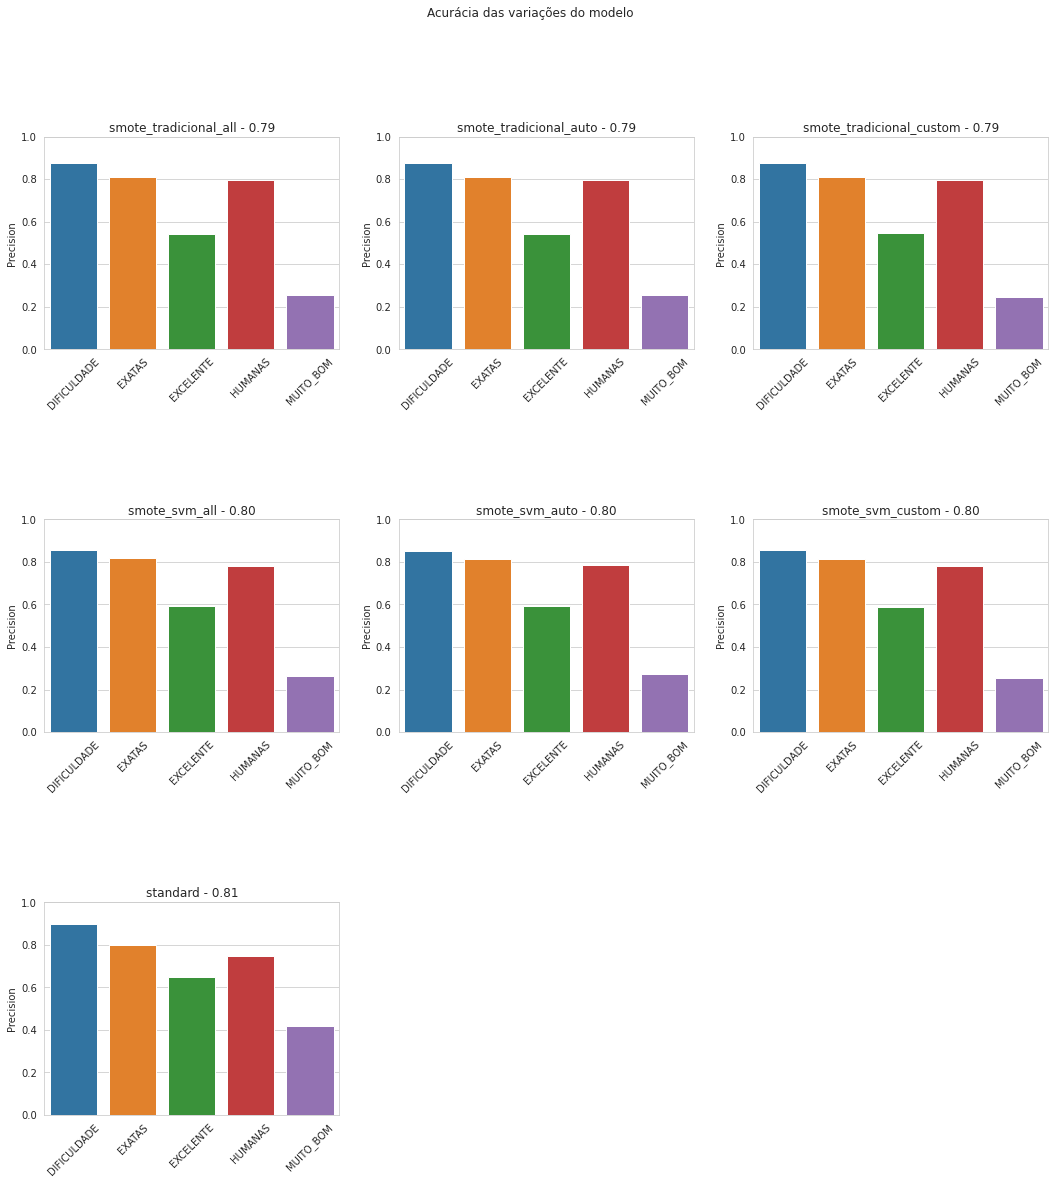

In [87]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

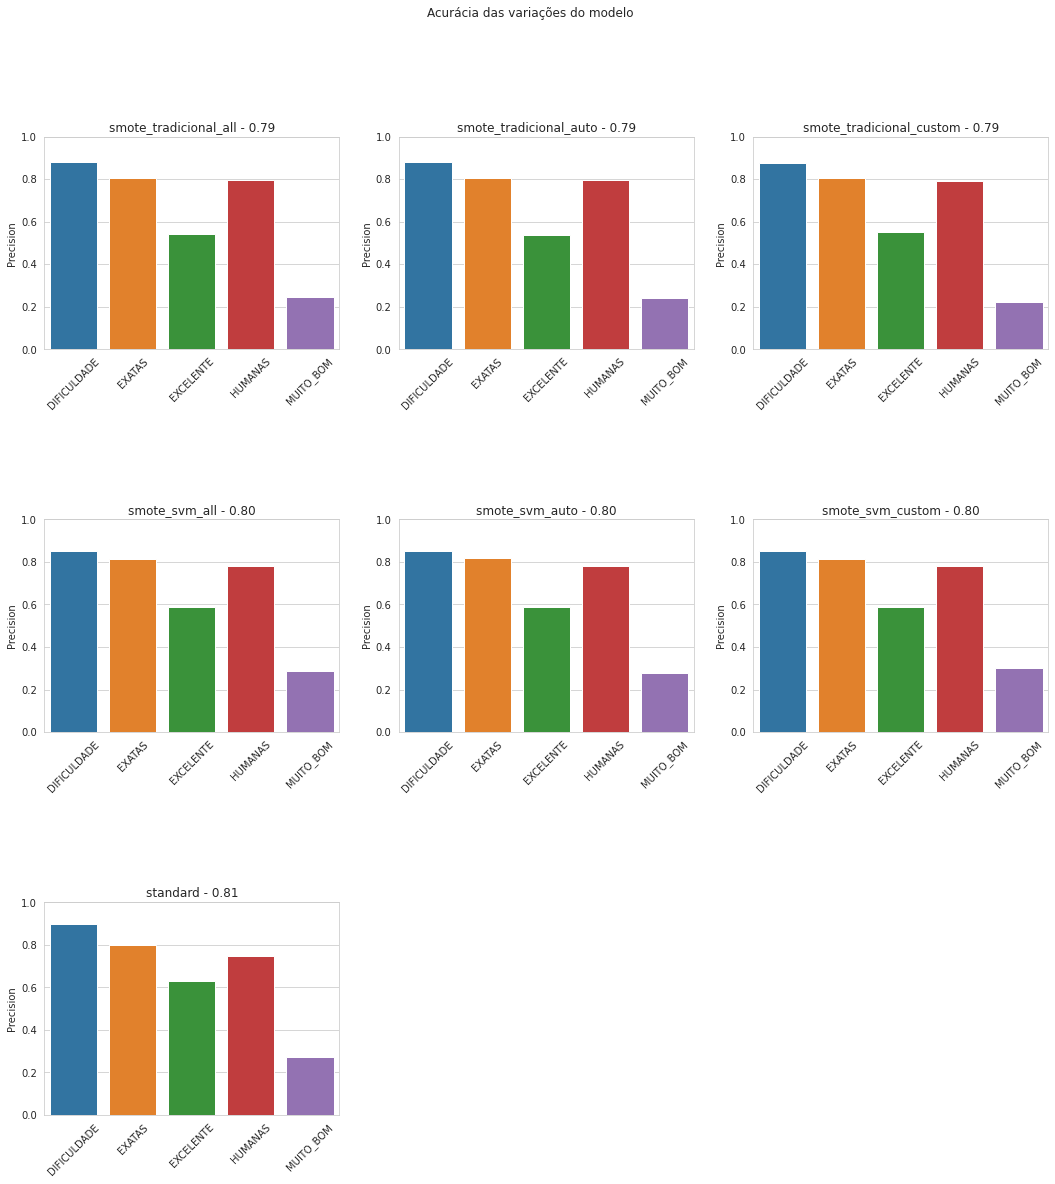

In [92]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

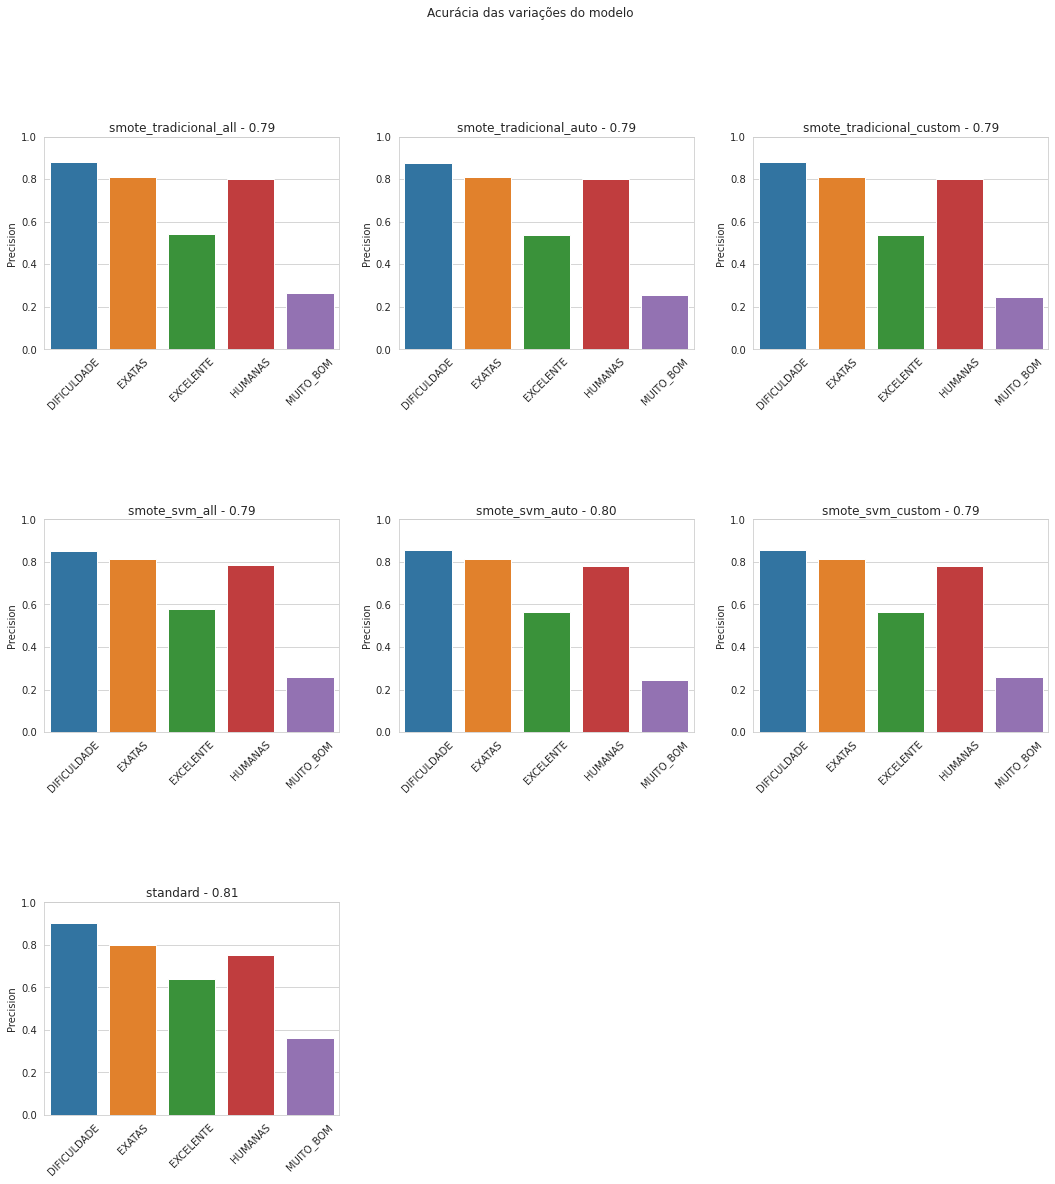

In [88]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [83]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

KeyboardInterrupt: ignored

### XGBoost

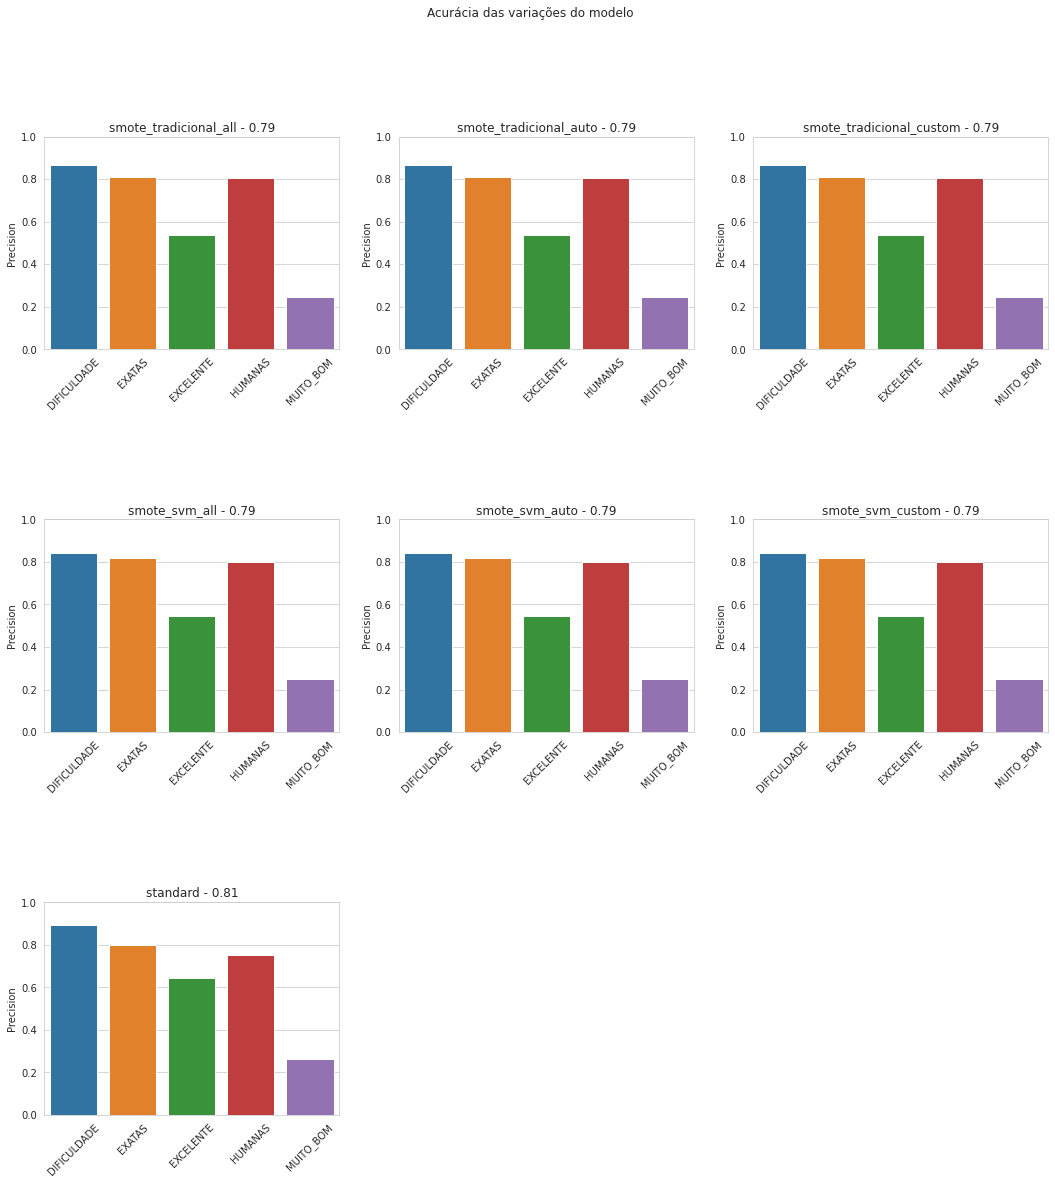

In [89]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

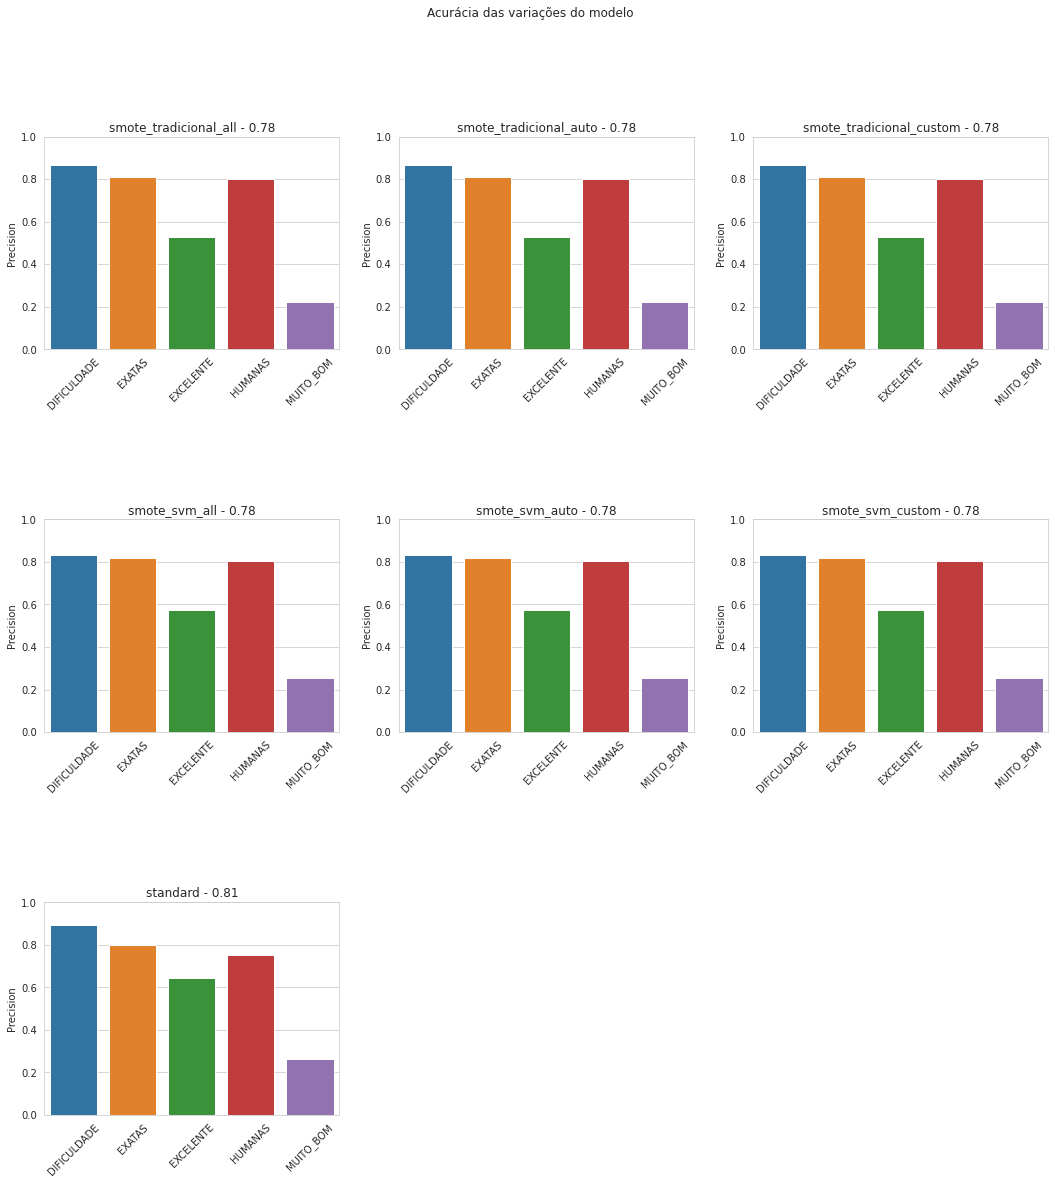

In [90]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

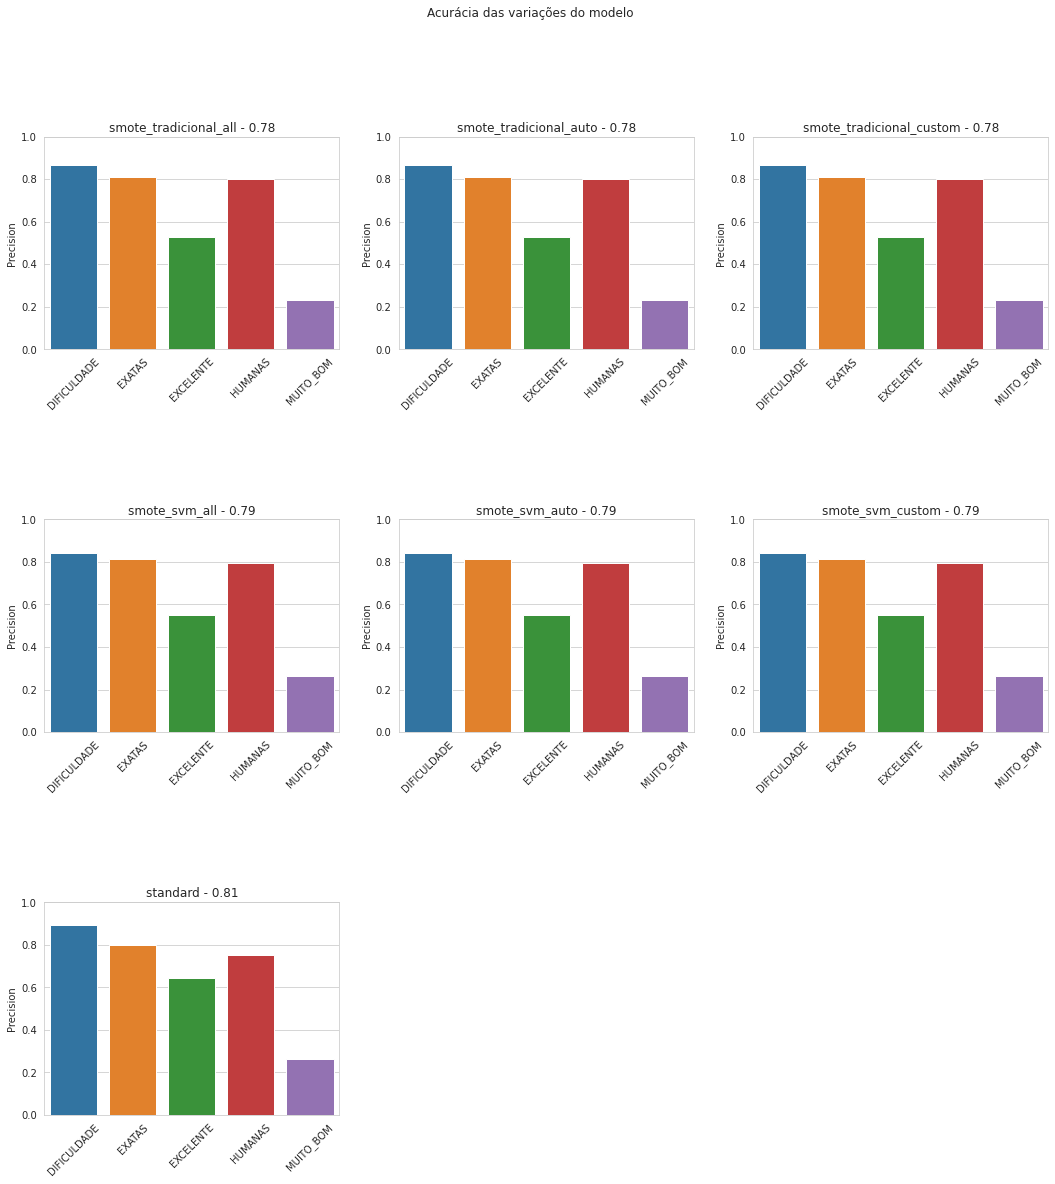

In [91]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns, ColumnsTransformerGOINGLES

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
cf = ColumnsTransformerGOINGLES()

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(cf.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns, SimpleImputer, CombNotaReprov

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
si = SimpleImputerGOINGLES()
cnr = CombNotaReprov()

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(si.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cnr.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns, ColumnsTransformerGOINGLES, CombNotaReprov

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
cf = ColumnsTransformerGOINGLES()
cnr = CombNotaReprov()

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(cf.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cnr.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns, SimpleImputer, CombMedias

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
si = SimpleImputerGOINGLES()
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_GO', 'NOTA_EM'], 'NOTAS')

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(si.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cm.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns, ColumnsTransformerGOINGLES, CombMedias

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME'])
cf = ColumnsTransformerGOINGLES()
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_GO', 'NOTA_EM'], 'NOTAS')

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(cf.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cm.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns[Nota_go], SimpleImputer, CombMediasHumanas

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME', 'NOTA_GO'])
si = SimpleImputerGOINGLES()
cmh = CombMedias(['NOTA_EM', 'NOTA_DE'], 'HUMANAS')

# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(si.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cmh.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns[Nota_go], SimpleImputer, CombMediasHumanas, CombMedias

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME', 'NOTA_GO'])
si = SimpleImputerGOINGLES()
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_EM'], 'NOTAS')
cmh = CombMedias(['NOTA_EM', 'NOTA_DE'], 'HUMANAS')


# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(si.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cm.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cmh.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns[NOTAS, INGLES], FillNaN, CombMediasHumanas, CombMedias

In [94]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME', 'INGLES'])
fn = FillNan('NOTA_GO')
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_EM', 'NOTA_GO'], 'NOTAS')
cmh = CombMedias(['NOTA_EM', 'NOTA_DE'], 'HUMANAS')
dn = DropColumns(['NOTA_DE', 'NOTA_EM', 'NOTA_GO'])


# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(fn.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cm.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cmh.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(dn.fit_transform(df_ibm))

df_ibm

,PERFIL,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_MF,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,COMB_NOTAS,COMB_HUMANAS
0,EXATAS,0,0,0,0,4.6,2,4,3,5.625,6.00
1,EXATAS,0,0,0,0,5.2,2,4,3,5.475,6.10
2,HUMANAS,0,0,0,0,7.1,5,0,3,7.075,7.00
3,DIFICULDADE,1,3,1,1,0.0,4,4,4,0.000,0.00
4,DIFICULDADE,1,3,1,1,0.0,5,2,5,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...
19995,EXATAS,0,0,0,0,5.8,9,5,6,6.925,7.45
19996,DIFICULDADE,1,1,1,1,0.0,3,2,5,0.000,0.00
19997,EXCELENTE,0,0,0,0,8.3,8,3,1,7.750,7.75
19998,DIFICULDADE,0,0,1,1,0.0,3,2,6,2.850,5.70


### RandomForest

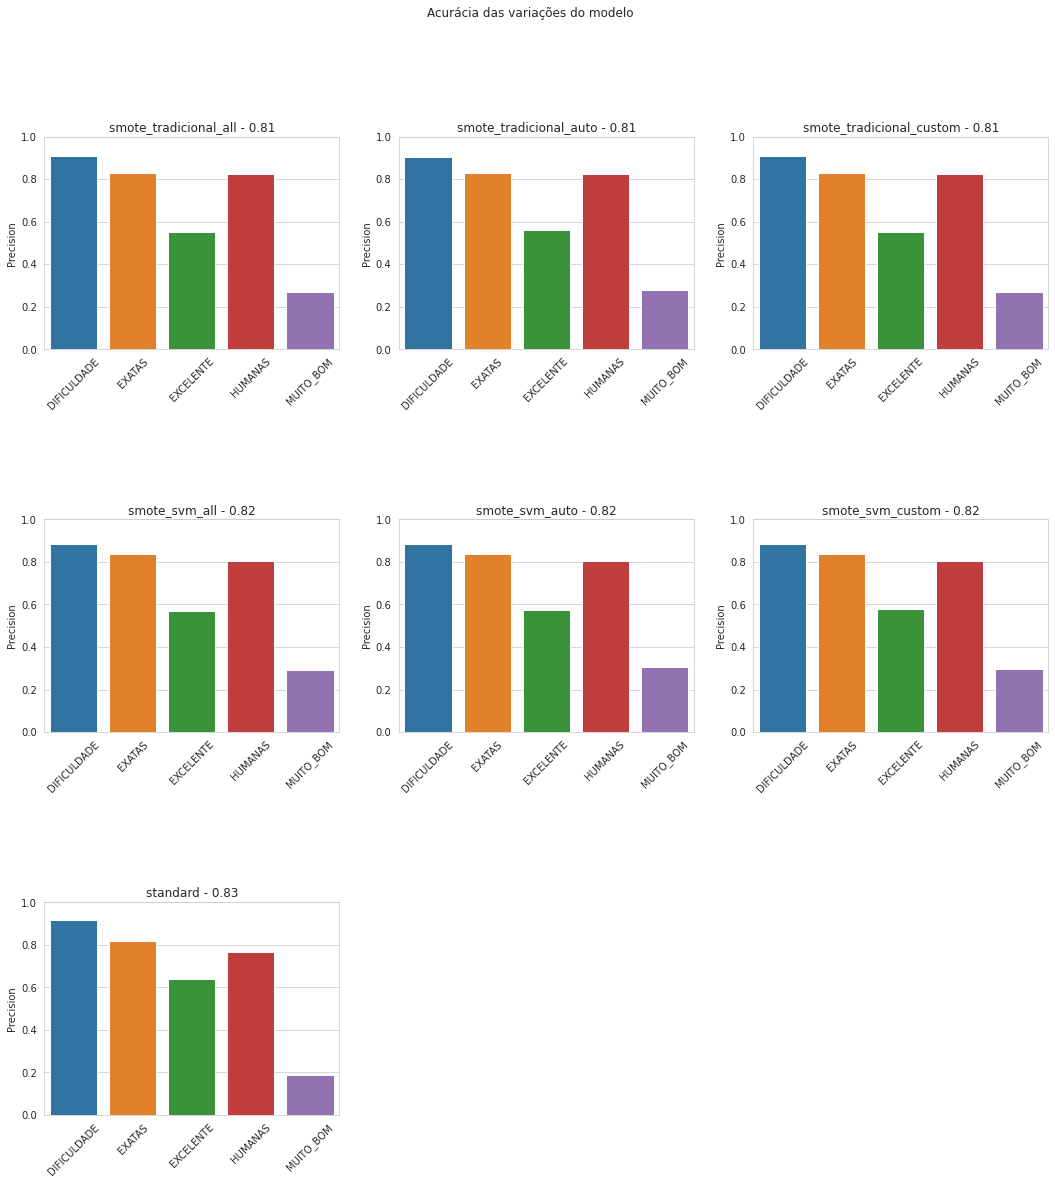

In [95]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

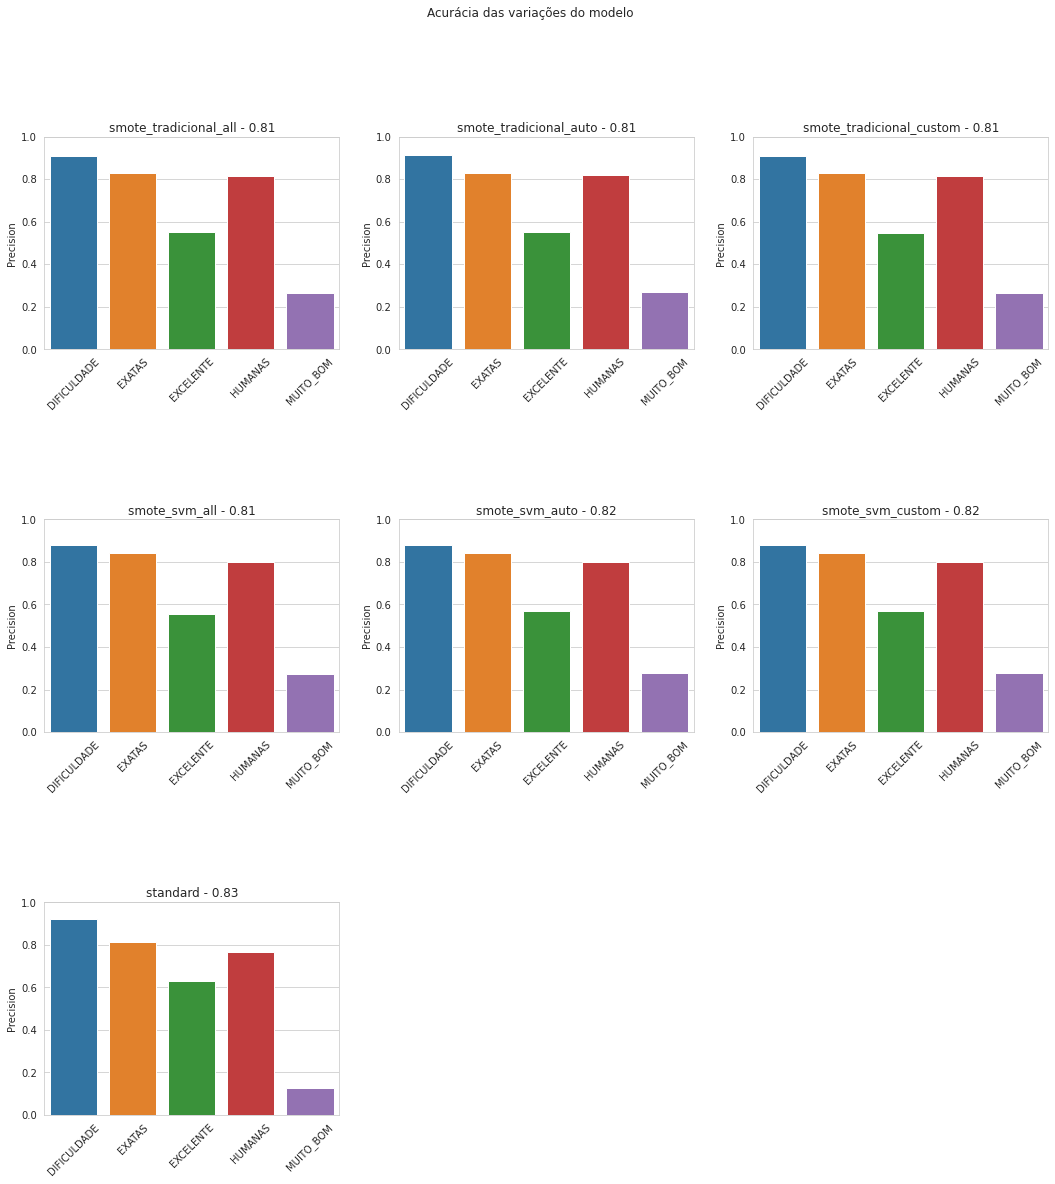

In [96]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

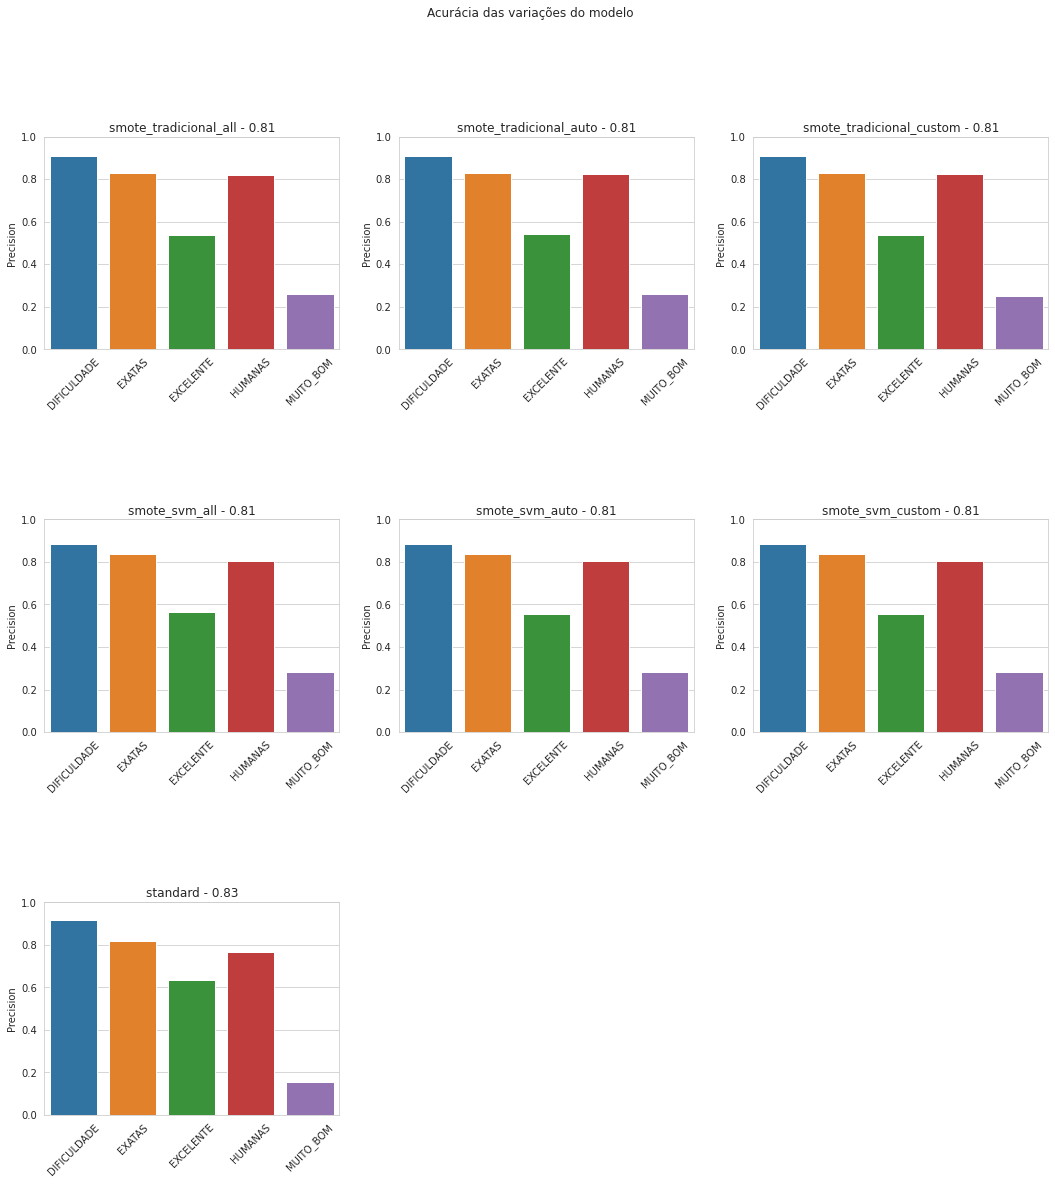

In [97]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

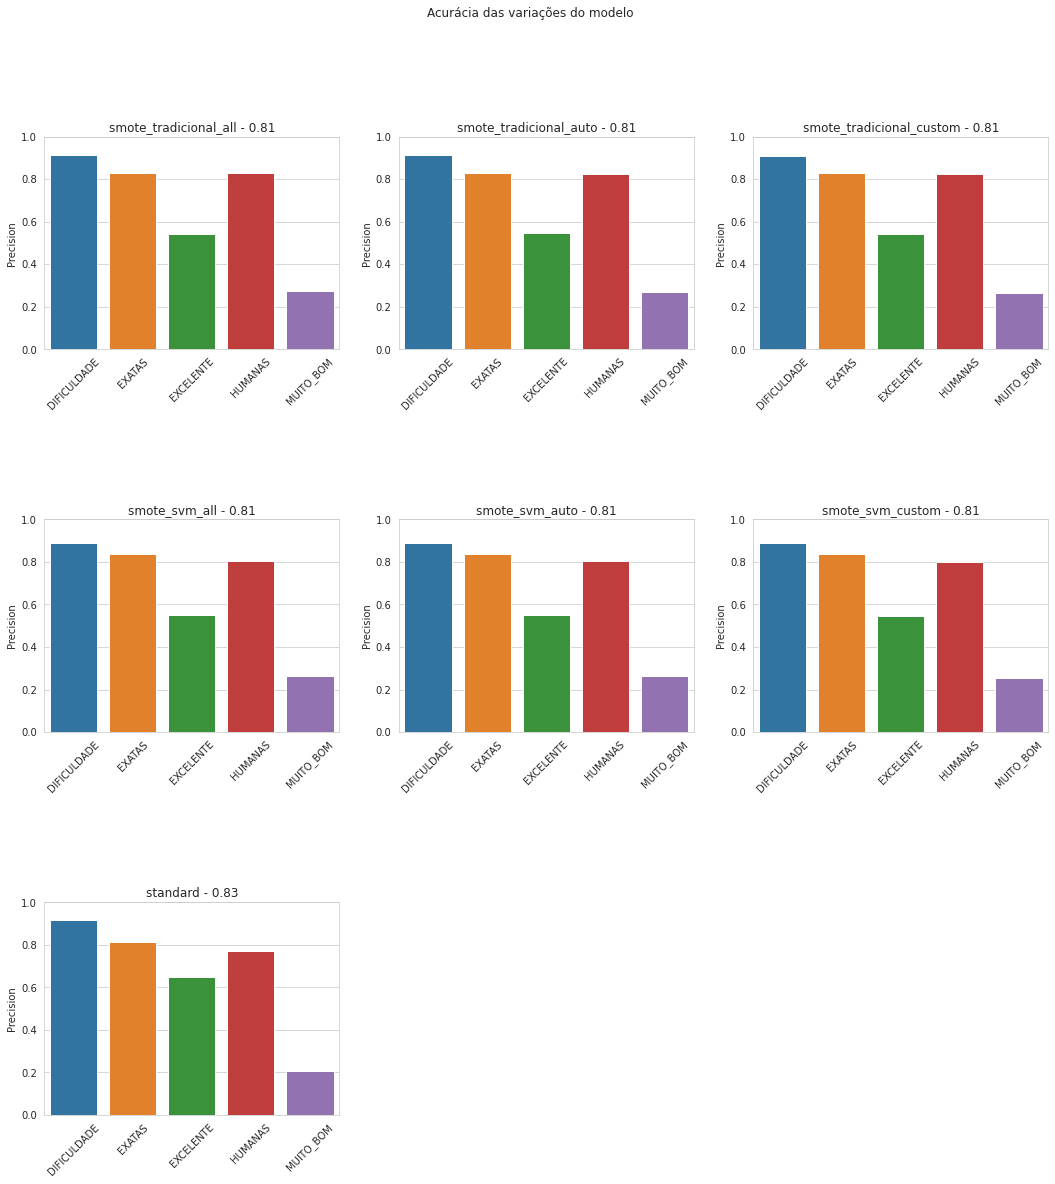

In [98]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

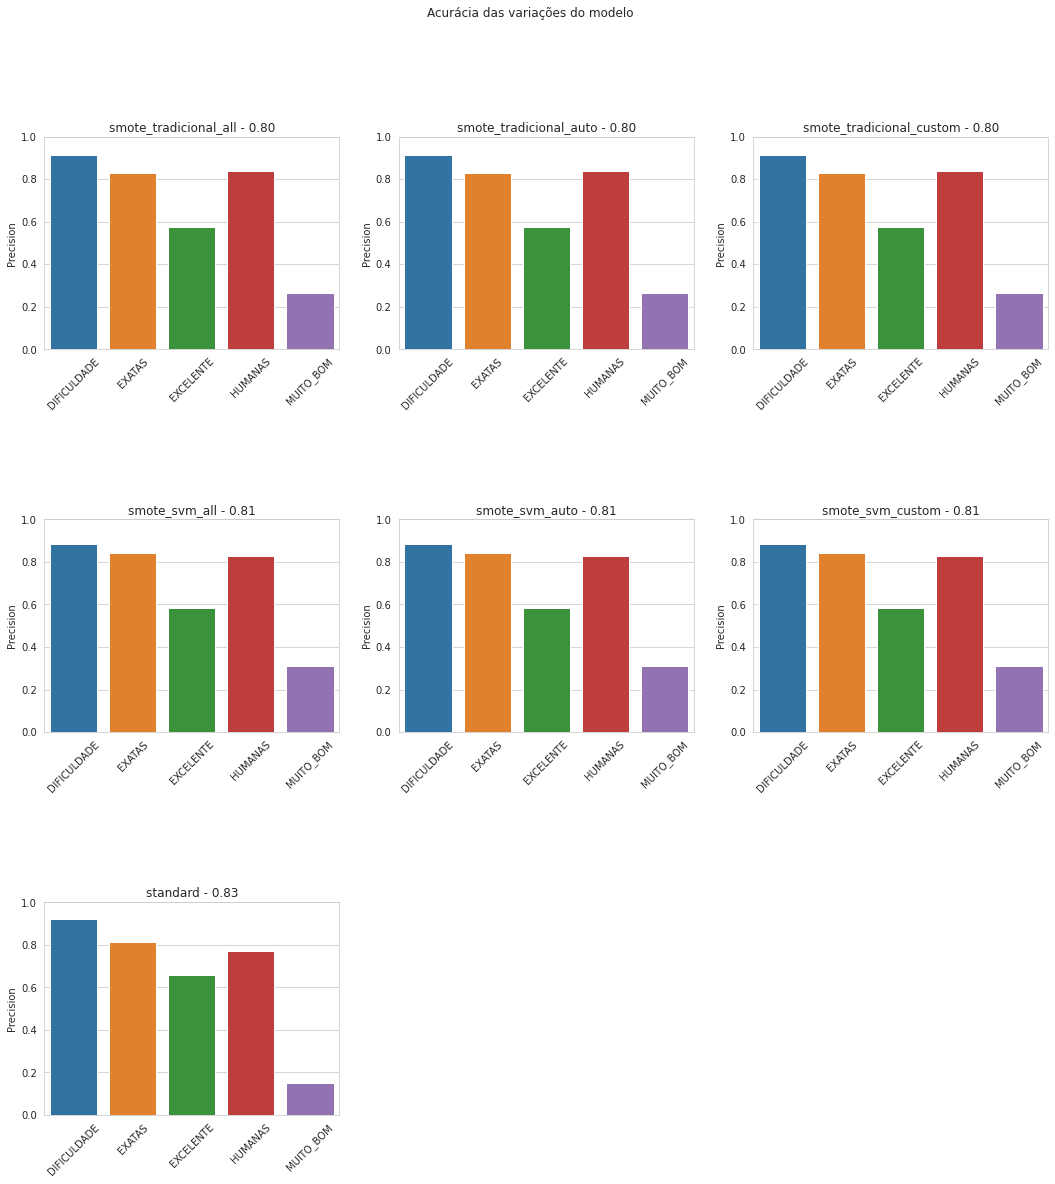

In [99]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

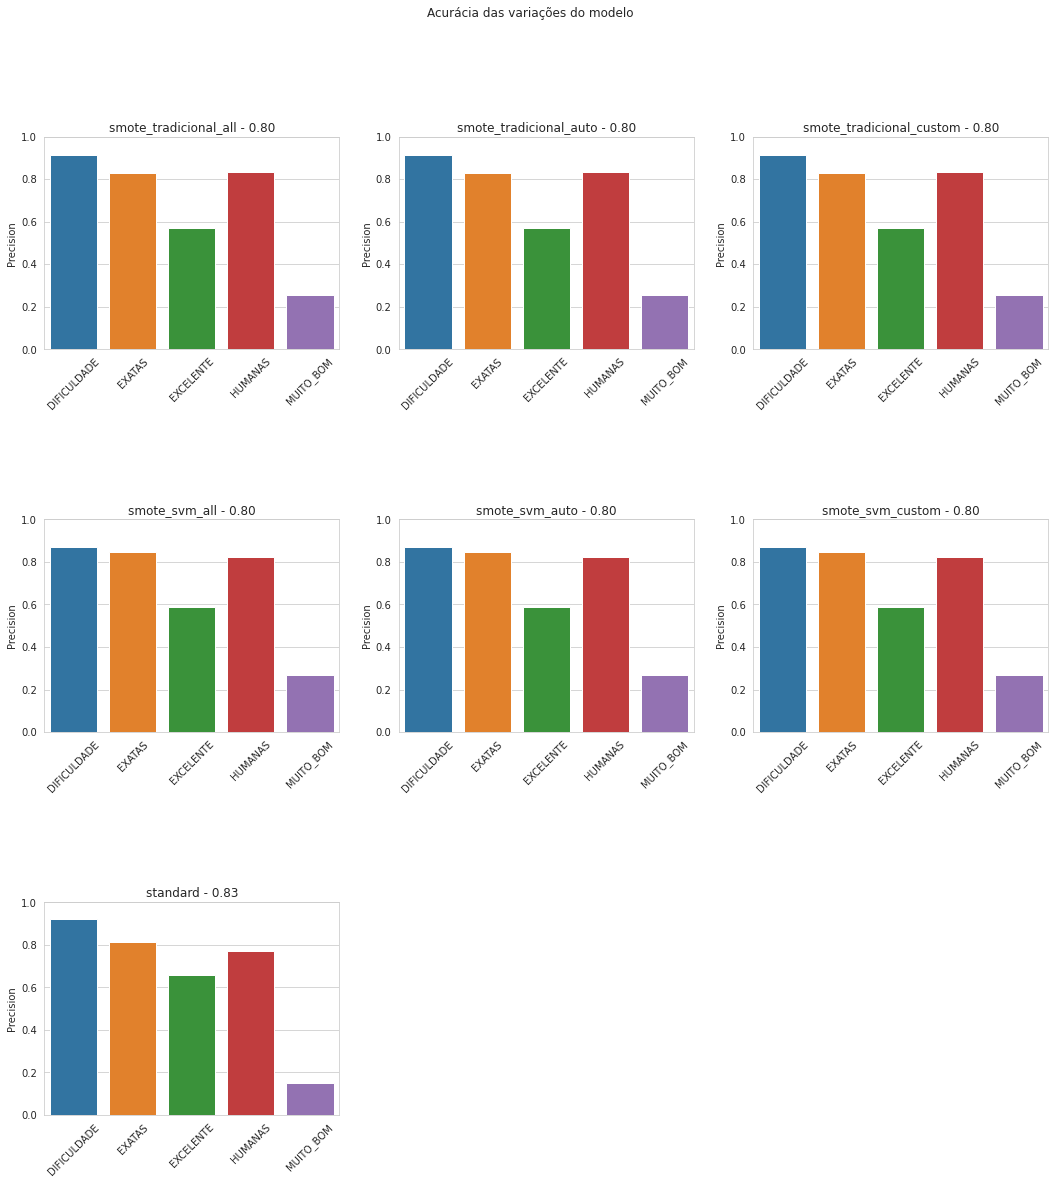

In [100]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

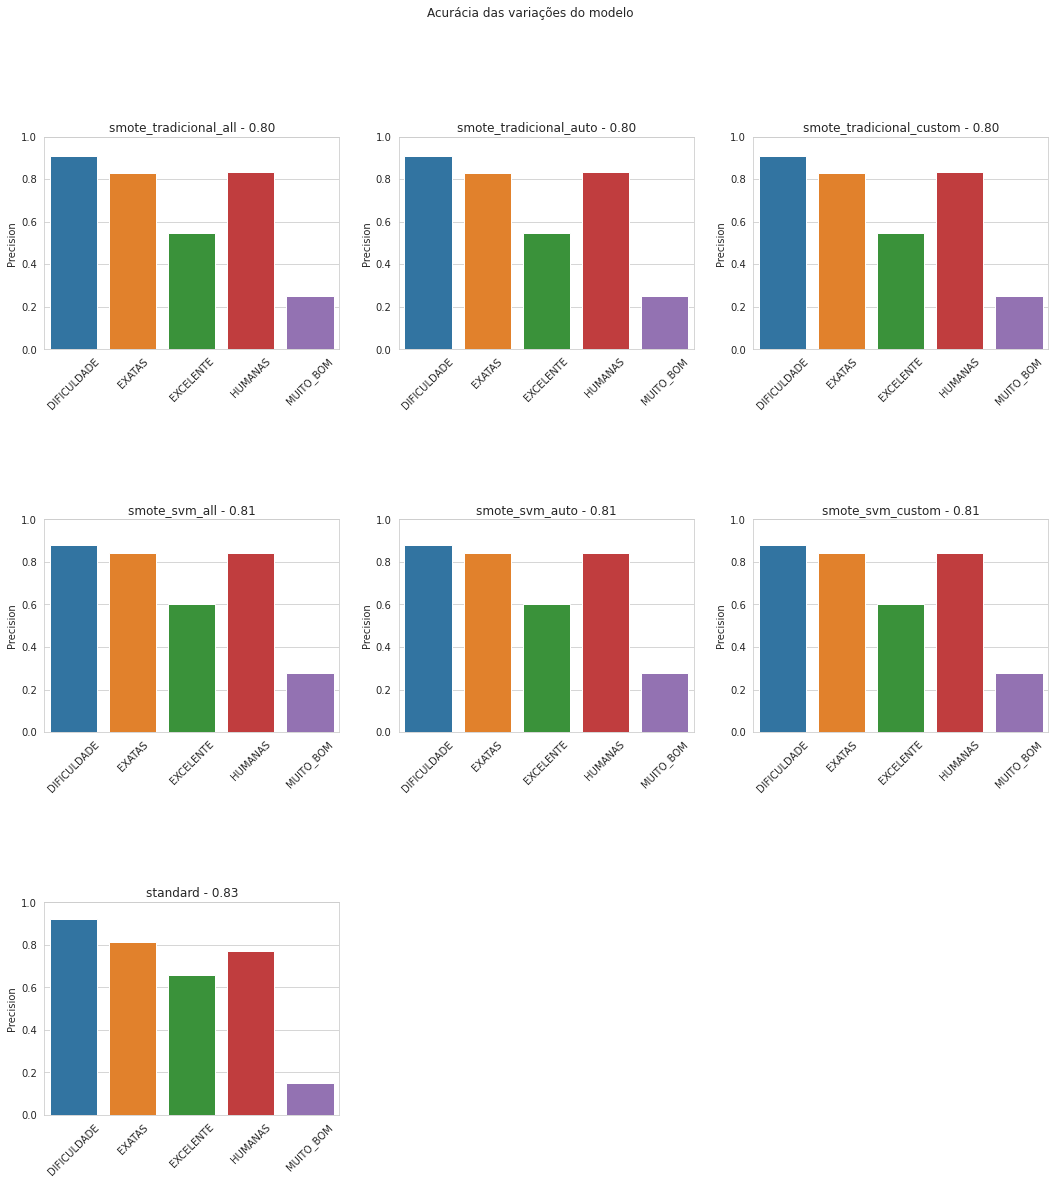

In [101]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

## DropColumns[NOTAS, INGLES, REPROVAÇÔES],FillNaN,CombMediasHumanas, CombMedias

In [ ]:
# objetos utilizados
rm_columns = DropColumns(['MATRICULA', 'NOME', 'INGLES', 'REPROVACOES_DE',
                          'REPROVACOES_MF', 'REPROVACOES_EM', 'REPROVACOES_GO'])
fn = FillNan('NOTA_GO')
cm = CombMedias(['NOTA_DE', 'NOTA_MF', 'NOTA_EM', 'NOTA_GO'], 'NOTAS')
cmh = CombMedias(['NOTA_EM', 'NOTA_DE'], 'HUMANAS')
dn = DropColumns(['NOTA_DE', 'NOTA_EM', 'NOTA_GO'])


# limpeza dos dados
df_ibm = pd.DataFrame.from_records(rm_columns.fit_transform(df))
df_ibm = pd.DataFrame.from_records(fn.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cm.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(cmh.fit_transform(df_ibm))
df_ibm = pd.DataFrame.from_records(dn.fit_transform(df_ibm))

df_ibm

### RandomForest

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### RandomForest, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### RandomForest, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### RandomForest, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = rf_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### XGBoost

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### XGBoost, RobustScaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### XGBoost, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### XGBoost, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = xgb_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

### StackingEstimator

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm)

### StackingEstimator, Robust Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='robust')

### StackingEstimator, Standard Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='standard')

### StackingEstimator, MinMax Scaler

In [ ]:
# modelo utilizado
dtc_model = stack_model

# Classificando por smote
plot_results(dtc_model, df_ibm, scaler='minmax')

# Tpot analise

In [ ]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(cv=5, generations=10, population_size=100,
                                    random_state=587, verbosity=2, n_jobs=-1)

X = df_ibm.drop(['PERFIL'], axis=1).to_numpy()
y = df_ibm['PERFIL'].astype("category").cat.codes.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=500)

pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))



In [ ]:
!pip install tpot